# 2D Detector Data Generation

I'm using this notebook to develop and test the generation and usage of 2D detector layer data.

I'll start with square unmasked detectors, and then think about masking afterwards.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from data import generate_uniform_noise

# Magic
%matplotlib notebook

## Utilities

In [2]:
def draw_layer(ax, data, title=None, **kwargs):
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, figsize=(9.5, 4.5)):
    num_layers = event.shape[0]
    nrows = math.ceil(float(num_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
    plt.tight_layout()

## Fixed square layers

In [3]:
# The data structure
num_event = 10000
num_layers = 10
num_seed_layers = 3
layer_size = 20
shape = (num_event, num_layers, layer_size, layer_size)

### Noise generation

In [4]:
def gen_noise_2d(shape, prob=0.1):
    return (np.random.random_sample(shape) < prob).astype(int)

<IPython.core.display.Javascript object>


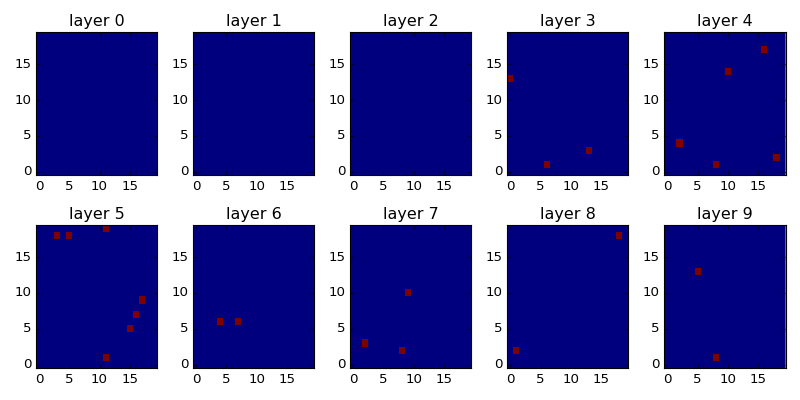

In [7]:
# Generate some uniform noise events
noise = gen_noise_2d(shape, prob=0.01)
# Zero out the seed layers
noise[:,:num_seed_layers,:,:] = 0
# Visualize the layers
draw_layers(noise[0], ncols=5, figsize=(10,5))

### Track generation

How do we represent a straight line track in this detector?
* The parameters are the two slopes and the two coordinates of the entry
* I can sample the entry and exit coordinates and then calculate the slopes
* Converting to hit indices is a straightforward extension of the 1D case

In [8]:
def gen_straight_tracks_2d(n, num_layers, layer_size):
    # Initialize the data
    data = np.zeros((n, num_layers, layer_size, layer_size))
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, layer_size, size=(n, 2))
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_layers - 1)
    # Calculate hit positions and fill hit data
    xhits = np.zeros(num_layers, dtype=np.int)
    yhits = np.zeros(num_layers, dtype=np.int)
    idx = np.arange(num_layers)
    for ievt in range(n):
        xhits[:] = slopes[ievt,0]*idx + entry_points[ievt,0]
        yhits[:] = slopes[ievt,1]*idx + entry_points[ievt,1]
        data[ievt,idx,xhits,yhits] = 1   
    return data

<IPython.core.display.Javascript object>


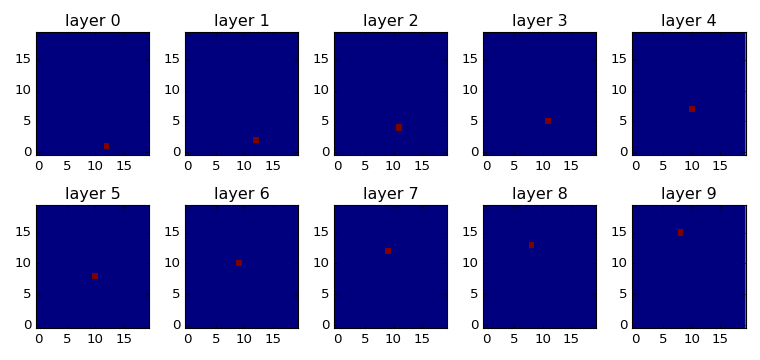

In [9]:
# Generate the track data
sig_tracks = gen_straight_tracks_2d(num_event, num_layers, layer_size)

# Visualize the first event
draw_layers(sig_tracks[0])

### Full event generation

Signal tracks, background tracks, and uniform noise

In [10]:
# It's easy to generate bkg events with a fixed number of tracks
bkg_tracks = sum(gen_straight_tracks_2d(num_event, num_layers, layer_size)
                 for i in range(4))

# Visualize one of these events
#draw_layers(bkg_tracks[0])

In [11]:
# It's a little trickier to generate a variable number of background tracks
def gen_bkg_tracks_2d(num_event, num_layers, layer_size, avg_bkg_tracks=3):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_layers, layer_size, layer_size))
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks_2d(ntrk, num_layers, layer_size))
    return bkg_tracks

In [12]:
bkg_tracks = gen_bkg_tracks_2d(num_event, num_layers, layer_size)
bkg_tracks[:,:num_seed_layers,:,:] = 0

# Visualize one of these events
#draw_layers(bkg_tracks[3])

In [13]:
# Putting it all together
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

<IPython.core.display.Javascript object>


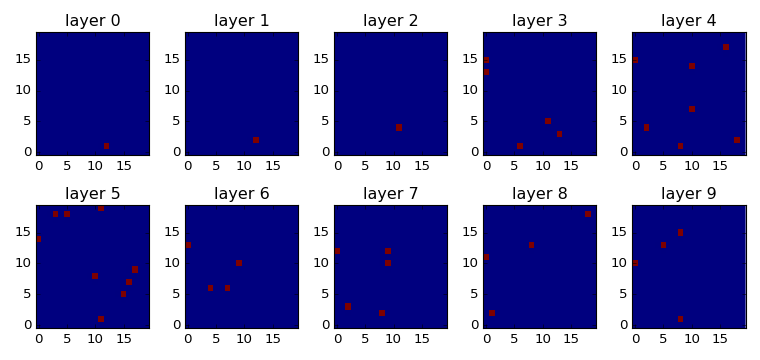

In [14]:
# Visualize
draw_layers(events[0])

## Projections

In [54]:
def draw_projections(event):
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    kwargs = dict(interpolation='none',
                  #aspect='auto',
                  origin='lower')
    plt.imshow(event.sum(axis=1).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.subplot(122)
    plt.imshow(event.sum(axis=2).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.tight_layout()

<IPython.core.display.Javascript object>


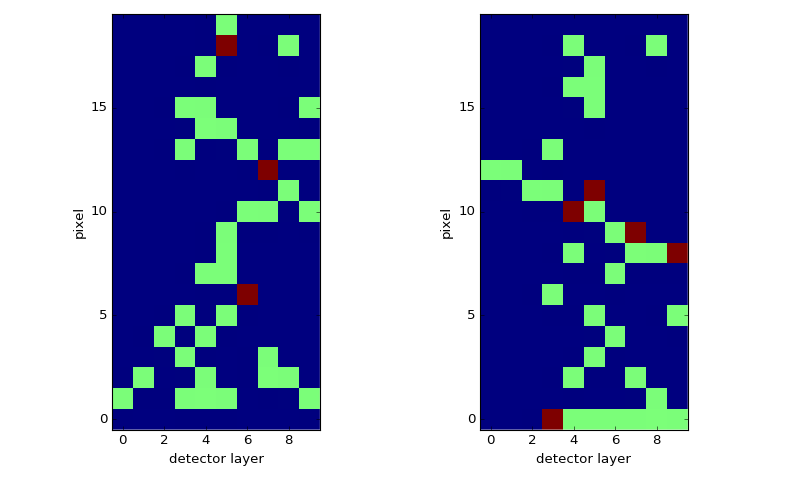

In [55]:
draw_projections(events[0])

## Discussion